In [1]:
from pathlib import Path
from course_intro_ocr_t1.data import MidvPackage
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

In [2]:
DATASET_PATH = Path().absolute().parent.parent / 'midv500_compressed'
assert DATASET_PATH.exists(), DATASET_PATH.absolute()

In [3]:
# Собираем список пакетов (MidvPackage) 
data_packs = MidvPackage.read_midv500_dataset(DATASET_PATH)
len(data_packs), type(data_packs[0])

C:\Users\asche\OneDrive\Документы\course_intro_ocr\task1\course_intro_ocr_t1\data.py:42: UnicodeWarning: Can't read C:\Users\asche\OneDrive\Документы\midv500_compressed\08_chn_homereturn\ground_truth\08_chn_homereturn.json, non unicode text
  warnings.warn(f"Can't read {self.gt_path}, non unicode text", UnicodeWarning)
C:\Users\asche\OneDrive\Документы\course_intro_ocr\task1\course_intro_ocr_t1\data.py:42: UnicodeWarning: Can't read C:\Users\asche\OneDrive\Документы\midv500_compressed\10_cze_id\ground_truth\10_cze_id.json, non unicode text
  warnings.warn(f"Can't read {self.gt_path}, non unicode text", UnicodeWarning)
C:\Users\asche\OneDrive\Документы\course_intro_ocr\task1\course_intro_ocr_t1\data.py:42: UnicodeWarning: Can't read C:\Users\asche\OneDrive\Документы\midv500_compressed\31_jpn_drvlic\ground_truth\31_jpn_drvlic.json, non unicode text
  warnings.warn(f"Can't read {self.gt_path}, non unicode text", UnicodeWarning)
C:\Users\asche\OneDrive\Документы\course_intro_ocr\task1\cour

(50, course_intro_ocr_t1.data.MidvPackage)

In [4]:
# В каждом пакете - 300 штук DataItem
dp = data_packs[0]
di = dp[220]
type(dp), len(dp), type(di)


(course_intro_ocr_t1.data.MidvPackage, 300, course_intro_ocr_t1.data.DataItem)

# Посмотрим на данные

In [5]:
# DataItem содержит пути до файлов изображения и разметки
di.gt_path, di.img_path

(WindowsPath('C:/Users/asche/OneDrive/Документы/midv500_compressed/01_alb_id/ground_truth/PS/PS01_11.json'),
 WindowsPath('C:/Users/asche/OneDrive/Документы/midv500_compressed/01_alb_id/images/PS/PS01_11.tif'))

In [6]:
# в gt_data (данные json) quad в абсолютных значениях (пиксели)
np.array(di.gt_data['quad'])

array([[220, 299],
       [598, 315],
       [626, 571],
       [202, 541]])

[[0.48888889 0.37375   ]
 [1.32888889 0.39375   ]
 [1.39111111 0.71375   ]
 [0.44888889 0.67625   ]]


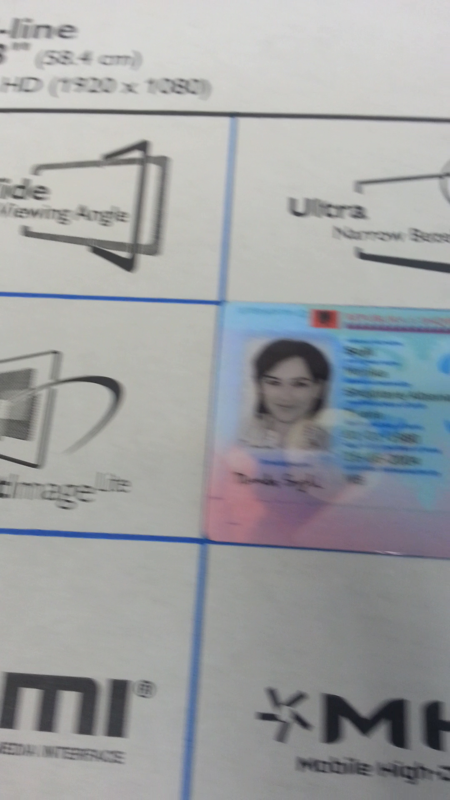

In [7]:
# Можно посмотреть изображения и разметку; в .quadrangle используются относительные единицы
print(di.quadrangle)
di.image

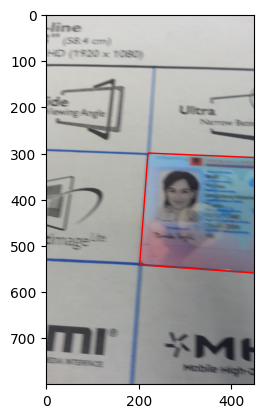

In [8]:
# Можно отрисовать разметку
# Не обязательно весь документ виден в кадре
di.show()

In [9]:
# DataItem содержит в себе информацию, относится ли он к test_split и целиком ли разметка внутри кадра
di.is_test_split(), di.is_quad_inside()

(False, False)

True


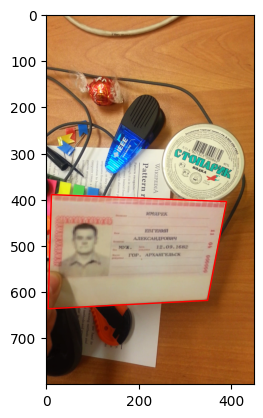

In [10]:
print(data_packs[38][238].is_test_split())
data_packs[38][238].show()

In [11]:
img2 = np.array(data_packs[38][238].image).copy() # "orig"
img1 = np.array(data_packs[38].template_item.image).copy() # template

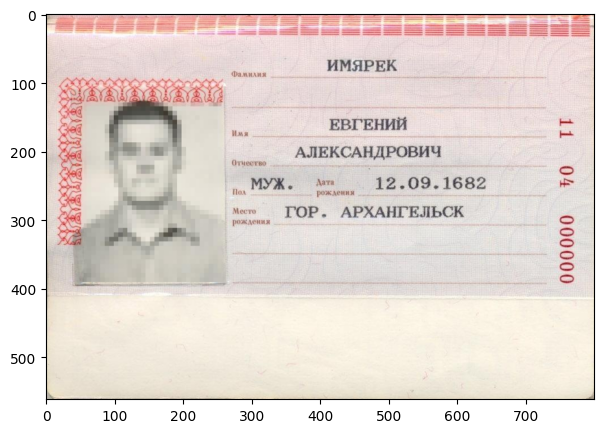

In [12]:
plt.figure(figsize=(8, 5))
plt.imshow(img1)
plt.show()

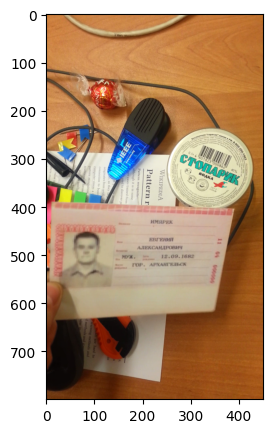

In [13]:
plt.figure(figsize=(8, 5))
plt.imshow(img2)
plt.show()

# Кроп

algorithm by https://docs.opencv.org/4.x/d1/de0/tutorial_py_feature_homography.html

In [14]:
!pip3 install opencv-python

In [15]:
import cv2 as cv

In [16]:
MIN_MATCH_COUNT = 10

# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1, des2, k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

[[[ 12.0245285 390.3438   ]]

 [[  3.5454261 637.9763   ]]

 [[346.85587   614.99994  ]]

 [[386.5953    405.82806  ]]]


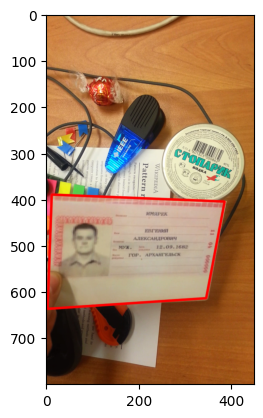

In [17]:
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
 
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()
    
    h, w, _ = img1.shape
    pts = np.float32([[0,0], [0,h - 1], [w - 1,h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    dst = cv.perspectiveTransform(pts, M)
    
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
    print(dst)
    plt.imshow(img2, 'gray'),plt.show()
else:
    print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
    matchesMask = None

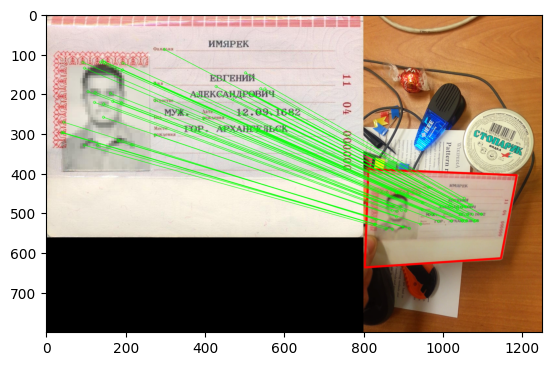

(<matplotlib.image.AxesImage at 0x185f465fa70>, None)

In [18]:
draw_params = dict(matchColor = (0, 255, 0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
 
img3 = cv.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)

plt.imshow(img3, 'gray'),plt.show()

# Соберём всё вместе и протестируем

In [19]:
def crop(img1, img2): # template, to_detect
    
    # Initiate SIFT detector
    sift = cv.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    
    flann = cv.FlannBasedMatcher(index_params, search_params)
    
    matches = flann.knnMatch(des1, des2, k=2)
    
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
 
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    
    h, w, _ = img1.shape
    pts = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)
    h, w, _ = img2.shape
    dst = cv.perspectiveTransform(pts, M) /  np.array([[w, h]])
    
    return dst.reshape(-1, 2)

In [20]:
dp = data_packs[38]

In [21]:
pred_quad = crop(np.array(dp.template_item.image), np.array(dp[38].image))

In [22]:
pred_quad.shape, dp[38].quadrangle.shape

((4, 2), (4, 2))

In [23]:
pred_quad, dp[38].quadrangle

(array([[ 0.02846023,  0.38010368],
        [ 0.64932319,  0.41215931],
        [ 0.62031772,  0.6542131 ],
        [-0.04351262,  0.62715618]]),
 array([[ 0.02666667,  0.38      ],
        [ 0.64888889,  0.41125   ],
        [ 0.62444444,  0.6575    ],
        [-0.03333333,  0.6275    ]]))

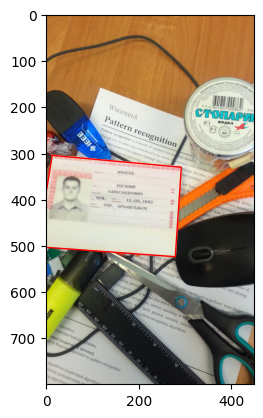

In [24]:
dp[38].show(pred_quad)

In [25]:
results_dict = dict()

for dp in tqdm(data_packs):
    for i in range(len(dp)):
        if dp[i].is_test_split():
            try:
                results_dict[dp[i].unique_key] = crop(np.array(dp.template_item.image), np.array(dp[i].image))
            except Exception as exc:
                # Для пропущенных в словаре ключей в метриках автоаматически засчитается IoU=0
                print(exc)

 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [10:03<03:21, 15.49s/it]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'



 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [11:41<01:52, 16.00s/it]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'cv::perspectiveTransform'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'cv::perspectiveTransform'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'cv::perspectiveTransform'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'cv::perspectiveTransform'

OpenCV(4.9.

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [22:49<00:00, 27.39s/it]


# Сохраним результаты и измерим точность
Результаты - словарь с ключем DataItem.unique_key() и значением предсказанным quadrangle в относительных единицах.

In [26]:
from course_intro_ocr_t1.metrics import dump_results_dict, measure_crop_accuracy

In [27]:
dump_results_dict(results_dict, Path() / 'pred.json')

In [28]:
acc = measure_crop_accuracy(
    Path() / 'pred.json',
    Path() / 'gt.json'
)

In [29]:
print("Точность кропа: {:1.4f}".format(acc))

Точность кропа: 0.9647
